In [2]:
import yfinance as yf
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

C:\Users\HP\AppData\Local\Temp\ipykernel_104584\4090672181.py:23: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download(ticker, interval = INTERVAL, period = PERIOD)
[*********************100%***********************]  1 of 1 completed


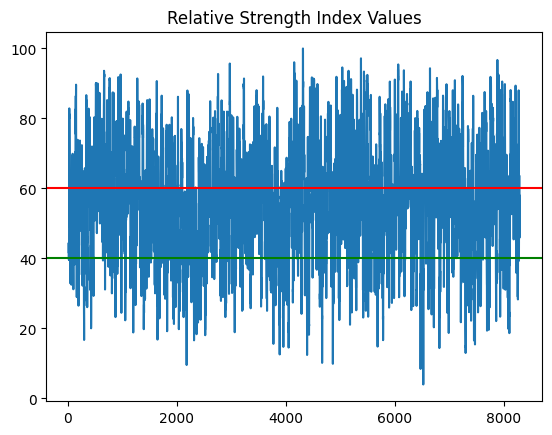

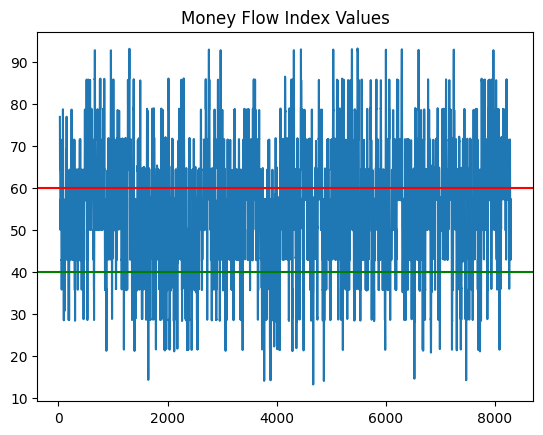

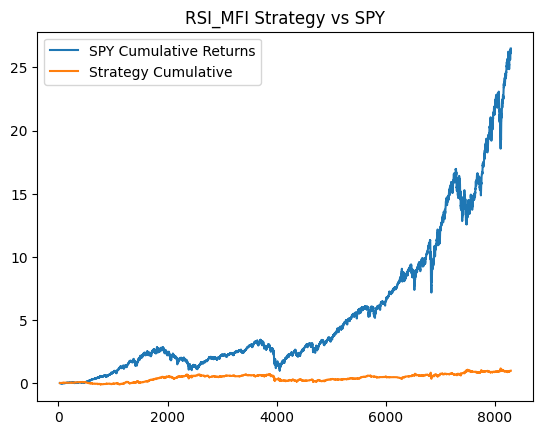

In [16]:
TICKER = 'SPY'
RSI_LENGTH = 14
MFI_LENGTH = 14
RSI_OVERBOUGHT = 60
RSI_OVERSOLD = 40
MFI_OVERBOUGHT = 60
MFI_OVERSOLD = 40
LOOKBACK = 10000
INTERVAL = '1d'

#Set period based on interval
if INTERVAL == '1h':
    PERIOD = '730d'
else:
    PERIOD = 'max'

#what subsection of data are you interested in


def get_data(ticker = TICKER, lookback =  LOOKBACK, interval = INTERVAL):

    #get data at interval you want
    df = yf.download(ticker, interval = INTERVAL, period = PERIOD) 
    df.columns = df.columns.get_level_values(0)

    #reset the index to make plots prettier
    df = df.reset_index(drop = True)

    # only return the subset of data you are interested in
    return df.iloc[-lookback:, :]

def add_RSI(df, length = RSI_LENGTH, overbought= RSI_OVERBOUGHT, oversold = RSI_OVERSOLD):
    price_change = df['Close'].diff()
    # separategains/losses
    gain = price_change.where(price_change > 0, 0)
    loss = -price_change.where(price_change < 0, 0) #negative sign i crucial to factor in loss

    # average gain vs loss
    avg_gain = gain.rolling(window = length).mean()
    avg_loss = loss.rolling(window = length).mean()

    rs= avg_gain/avg_loss
    rsi = 100 - (100 /(1 + rs))

    df['RSI'] = rsi

    #plot thenrelative strength index
    plt.plot(df['RSI'])
    plt.axhline(overbought, color = 'red')
    plt.axhline(oversold, color = 'green')
    plt.title('Relative Strength Index Values')

    return df.dropna()

def add_RSI_strategy(df, overbought = RSI_OVERBOUGHT, oversold= RSI_OVERSOLD):
    df['RSI_Strategy'] = 0
    df['RSI_Strategy'] = np.where(df['RSI'] > overbought, -1,
                     np.where(df['RSI'] < oversold, 1, 0))

    #shift back to make sure we have sen the signal
    df['RSI_Strategy'] = df['RSI_Strategy'].shift(1)

    return df

def add_MFI(df, length = MFI_LENGTH, overbought = MFI_OVERBOUGHT, oversold = MFI_OVERSOLD):
    df['Average_Price'] = (df['High'] + df['Low'] + df['Close'])/3
    df['Money_Flow']= df['Volume'] * df['Average_Price']

        #Initialize empty flows
    df['Positive_Flow'] = 0
    df['Negative_Flow'] = 0

    df['Positive_Flow']= np.where(df['Average_Price'].diff() > 0, df['Average_Price'], 0)
    df['Negative_Flow']= np.where(df['Average_Price'].diff() < 0, df['Average_Price'], 0)

    #money flow ratio
    mfr = df['Positive_Flow'].rolling(length).sum() /  df['Negative_Flow'].rolling(length).sum()

    #add money flow column
    df['MFI'] = 100 - (100 / (1 + mfr))
   

     #plot the Money Flow index
    plt.figure()
    plt.plot(df['MFI'])
    plt.axhline(overbought, color = 'red')
    plt.axhline(oversold, color = 'green')
    plt.title('Money Flow Index Values')
    
    return df.dropna()

def add_MFI_strategy(df, overbought = MFI_OVERBOUGHT, oversold= MFI_OVERSOLD):
    df['MFI_Strategy'] = 0
    df['MFI_Strategy'] = np.where(df['MFI'] > overbought, -1,
                     np.where(df['MFI'] < oversold, 1, 0))

    #shift back to make sure we have seen the signal
    df['MFI_Strategy'] = df['MFI_Strategy'].shift(1)

    return df

def add_full_strategy(df):
    df['Full_Strategy'] = df['RSI_Strategy'] + df['MFI_Strategy']
    df['Strategy'] = np.where(df['Full_Strategy'] == 2, 1,
                     np.where(df['Full_Strategy'] == -2, -1, 0))
    
    df['Strategy'] = df['Strategy'].shift(1)
    return df

def test_strategy(df):
    df['Asset_Returns'] = (1+ df['Close']. pct_change()).cumprod() - 1
    df['Strategy_Returns'] = (1+ df['Close']. pct_change() * df['Strategy']).cumprod() - 1
   

#plot the strategy returns
    plt.figure()
    plt.plot(df['Asset_Returns'])
    plt.plot(df['Strategy_Returns'])
    plt.legend([f'{TICKER} Cumulative Returns', 'Strategy Cumulative'])
    plt.title(f'RSI_MFI Strategy vs {TICKER}')
    return df

def main():
    df = get_data(ticker = TICKER, lookback =  LOOKBACK, interval = INTERVAL)
    df = add_RSI(df, length = RSI_LENGTH, overbought= RSI_OVERBOUGHT, oversold = RSI_OVERSOLD)
    df = add_RSI_strategy(df, overbought = RSI_OVERBOUGHT, oversold= RSI_OVERSOLD)
    df = add_MFI(df, length = MFI_LENGTH, overbought = MFI_OVERBOUGHT, oversold = MFI_OVERSOLD)
    df = add_MFI_strategy(df, overbought = MFI_OVERBOUGHT, oversold= MFI_OVERSOLD)
    df = add_full_strategy(df)
    df = test_strategy(df)
    return df

df = main()

In [14]:
df

Price,Close,High,Low,Open,Volume,RSI,RSI_Strategy,Average_Price,Money_Flow,Positive_Flow,Negative_Flow,MFI,MFI_Strategy,Full_Strategy,Strategy,Asset_Returns,Strategy_Returns
26,25.155199,25.206923,25.103475,25.189682,169300,80.000481,-1.0,25.155199,4.258775e+06,25.155199,0.000000,76.922384,NaN,NaN,NaN,NaN,NaN
27,25.206926,25.206926,25.051754,25.155202,194400,81.197150,-1.0,25.155202,4.890171e+06,25.155202,0.000000,78.608144,-1.0,-2.0,0.0,0.002056,0.000000
28,25.137960,25.293133,25.103478,25.224167,70900,77.586786,-1.0,25.178190,1.785134e+06,25.178190,0.000000,78.681436,-1.0,-2.0,-1.0,-0.000685,0.002736
29,24.879322,24.948288,24.724150,24.931046,643600,67.460194,-1.0,24.850586,1.599384e+07,0.000000,24.850586,71.551384,-1.0,-2.0,-1.0,-0.010967,0.013053
30,25.000025,25.000025,24.862094,24.862094,310800,69.696894,-1.0,24.954048,7.755718e+06,24.954048,0.000000,78.563036,-1.0,-2.0,-1.0,-0.006169,0.008138
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8286,687.010010,688.559998,686.580017,687.450012,47160700,56.211297,0.0,687.383341,3.241748e+10,0.000000,687.383341,57.265329,0.0,0.0,0.0,26.310856,1.024171
8287,681.919983,687.359985,681.710022,687.140015,74144800,46.281283,0.0,683.663330,5.069008e+10,0.000000,683.663330,50.111757,0.0,0.0,0.0,26.108511,1.024171
8288,683.169983,686.869995,679.820007,685.710022,89377200,45.898018,0.0,683.286662,6.107025e+10,0.000000,683.286662,42.954044,0.0,0.0,0.0,26.158202,1.024171
8289,687.719971,689.429993,686.380005,686.539978,71927200,58.747526,0.0,687.843323,4.947464e+10,687.843323,0.000000,50.116790,0.0,0.0,0.0,26.339079,1.024171
